In [1]:
import re
import numpy as np
import pandas as pd
import subprocess

from matplotlib import pyplot as plt
from scipy.io import arff
from scipy.stats import zscore

from DBA_multivariate import performDBA

In [28]:
random_state = np.random.RandomState(42)

data1 = pd.DataFrame(arff.loadarff("../data/MultivariateTSCProblems/CharacterTrajectories/CharacterTrajectoriesDimension1_TRAIN.arff")[0])
data2 = pd.DataFrame(arff.loadarff("../data/MultivariateTSCProblems/CharacterTrajectories/CharacterTrajectoriesDimension2_TRAIN.arff")[0])
data3 = pd.DataFrame(arff.loadarff("../data/MultivariateTSCProblems/CharacterTrajectories/CharacterTrajectoriesDimension3_TRAIN.arff")[0])

data = [data1, data2, data3]
for d in data:
    d.iloc[:, -1] = d.iloc[:, -1].astype(np.int)

In [30]:
np.vstack([dim.iloc[idx, :-1].values for dim in data]).shape

(3, 182)

In [3]:
labels = data[0].iloc[:, -1].unique()
example_idxs = [data1[data1.iloc[:, -1] == label].sample(12, random_state=random_state).index for label in labels]

examples = []
for label_id, label in enumerate(labels):
    examples.append([zscore(np.vstack([dim.iloc[idx, :-1].values for dim in data]), 1) for idx in example_idxs[label_id]])
    
for idx, d in enumerate(data):
    data[idx] = d[~d.index.isin(np.concatenate(example_idxs))].reset_index(drop=True)

In [48]:
idxs = data[0].sample(frac=1, random_state=random_state).index
keys = data[0].iloc[idxs, -1]
for idx, d in enumerate(data):
    data[idx] = d.iloc[idxs, :-1]

timeseries = zscore(np.vstack([zscore(d.values, 1).reshape(1, -1).squeeze() for d in data]), 1)
keys = pd.DataFrame({"start": [data[0].shape[1] * i for i in range(len(keys))], "labels": keys.values})

In [5]:
np.savetxt("../data/search_subseries/character/tmp.csv", timeseries[:, keys[keys.labels==13].iloc[0, 0] : keys[keys.labels==13].iloc[0, 0] + 182])
averaged = list(map(lambda x: np.average(x, axis=0), examples))
for idx, example in enumerate(averaged):
    np.savetxt("../data/search_subseries/character/averaged_{0}.csv".format(idx + 1), example.T)

In [ ]:
dba_averaged_examples = list(map(performDBA, examples))

In [25]:
np.savetxt("../data/search_subseries/character/character_trajectories.csv", timeseries.T)
keys.to_csv("../data/search_subseries/character/character_trajectories_labels.csv")

for idx, example in enumerate(dba_averaged_examples):
    np.savetxt("../data/search_subseries/character/averaged_{0}.csv".format(idx + 1), example.T)

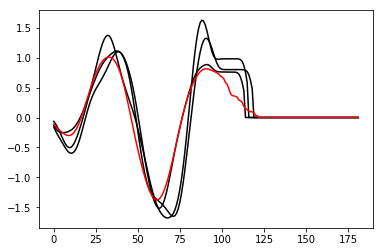

In [44]:
series = [timeseries[:, start:start + 182].T for start in keys[keys.labels == 4].sample(4).start.values]
plt.plot(series[0][:, 1], color="black")
plt.plot(series[1][:, 1], color="black")
plt.plot(series[2][:, 1], color="black")

plt.plot(averaged[4][1].T,color="r")

# UCR

In [54]:
warp_window = 0.1
subseq_len = 100
closest_series_num = 80

command = [r"bin/UCR_MDTW.exe", "../data/search_subseries/character/character_trajectories.csv", "../data/search_subseries/character/averaged_20.csv",
           str(subseq_len), str(warp_window), str(closest_series_num)]

In [55]:
stdout = subprocess.check_output(command).decode()
regexp = \
       r"\r\nLocation\s+:\s+(?P<location>\w+)\r\n" + \
        "Distance\s+:\s+(\d+\.\d+)\r\n" + \
        "Data Scanned\s+:\s+(\w+)\r\n" + \
        "Total Execution Time\s+:\s+(\d+\.\d+) sec\r\n\r\n" + \
        "Pruned by LB_Kim\s+:\s+(\d+\.\d+)%\r\n" + \
        "Pruned by LB_Keogh\s+:\s+(\d+\.\d+)%\r\n" + \
        "Pruned by LB_Keogh2\s+:\s+(\d+\.\d+)%\r\n" + \
        "DTW Calculation\s+:\s+(\d+\.\d+)%\r\n" + \
        "\r\nlocate\s+dist\r\n----------------\r\n" + \
        closest_series_num * "(\d+)\s+(\d+\.\d+)\r\n"

closest = {}
m_result = re.match(regexp, stdout)
if m_result:
    location, distance = m_result.groups()[:2]
    location = int(location)
    distance = float(distance)
    for loc, dist in zip(*[iter(m_result.groups()[8:])] * 2):
        closest[int(loc)] = float(dist)

# print(stdout)

In [58]:
tr = 0
for key in closest:
    tmp = keys[(keys.start > key - 100) & (keys.start < key + 100)]
#     print(key, tmp.start.values, tmp.labels.values)
    tr += sum(tmp.labels.values == 20)

In [7]:
x = np.loadtxt("../data/search_subseries/character/character_trajectories.csv")
y = np.loadtxt("../data/search_subseries/character/averaged_1.csv")

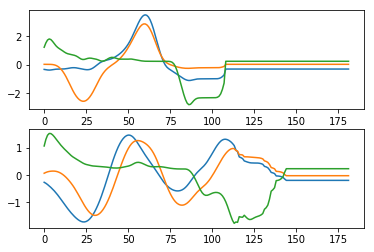

In [13]:
_ = plt.subplot(2, 1, 1).plot(x[182: 182 + 182])
_ = plt.subplot(2, 1, 2).plot(y)

In [61]:
np.unique(keys.labels, return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20]),
 array([73, 58, 59, 66, 81, 57, 51, 75, 50, 53, 58, 53, 50, 47, 54, 53, 65,
        50, 56, 73], dtype=int64))

# EPI

In [2]:
random_state = np.random.RandomState(42)

data_test_1 = pd.DataFrame(arff.loadarff("../data/MultivariateTSCProblems/Epilepsy/EpilepsyDimension1_TEST.arff")[0])
data_test_2 = pd.DataFrame(arff.loadarff("../data/MultivariateTSCProblems/Epilepsy/EpilepsyDimension2_TEST.arff")[0])
data_test_3 = pd.DataFrame(arff.loadarff("../data/MultivariateTSCProblems/Epilepsy/EpilepsyDimension2_TEST.arff")[0])

data_train_1 = pd.DataFrame(arff.loadarff("../data/MultivariateTSCProblems/Epilepsy/EpilepsyDimension1_TRAIN.arff")[0])
data_train_2 = pd.DataFrame(arff.loadarff("../data/MultivariateTSCProblems/Epilepsy/EpilepsyDimension2_TRAIN.arff")[0])
data_train_3 = pd.DataFrame(arff.loadarff("../data/MultivariateTSCProblems/Epilepsy/EpilepsyDimension2_TRAIN.arff")[0])

data1 = pd.concat([data_test_1, data_train_1])
data2 = pd.concat([data_test_2, data_train_2])
data3 = pd.concat([data_test_3, data_train_3])

data = [data1, data2, data3]

In [3]:
labels = data[0].iloc[:, -1].unique()
example_idxs = [data1[data1.iloc[:, -1] == label].sample(12, random_state=random_state).index for label in labels]

examples = []
for label_id, label in enumerate(labels):
    examples.append([zscore(np.vstack([dim.iloc[idx, :-1].values.astype(np.float64) for dim in data]), 1) for idx in example_idxs[label_id]])
    
for idx, d in enumerate(data):
    data[idx] = d[~d.index.isin(np.concatenate(example_idxs))].reset_index(drop=True)
    
idxs = data[0].sample(frac=1, random_state=random_state).index
keys = data[0].iloc[idxs, -1]
for idx, d in enumerate(data):
    data[idx] = d.iloc[idxs, :-1]

timeseries = zscore(np.vstack([zscore(d.values, 1).reshape(1, -1).squeeze() for d in data]), 1)
keys = pd.DataFrame({"start": [data[0].shape[1] * i for i in range(len(keys))], "labels": keys.values})

In [4]:
labels_dict = {label : i + 1 for i, label in enumerate(labels)}
keys.iloc[:, -1] = keys.iloc[:, -1].replace(labels_dict)
np.savetxt("../data/search_subseries/epi.csv", timeseries.T)
keys.to_csv("../data/search_subseries/epi_labels.csv")

dba_averaged_examples = list(map(performDBA, examples))
for idx, example in enumerate(dba_averaged_examples):
    np.savetxt("../data/search_subseries/dba_averaged_{0}.csv".format(idx + 1), example.T)
    
averaged = list(map(lambda x: np.average(x, axis=0), examples))
for idx, example in enumerate(dba_averaged_examples):
    np.savetxt("../data/search_subseries/averaged_{0}.csv".format(idx + 1), example.T)

In [5]:
labels

array([b'EPILEPSY', b'WALKING', b'RUNNING', b'SAWING'], dtype=object)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import os
%load_ext autoreload
%autoreload 2

from time import sleep, time
from threading import Thread
from scipy.cluster.hierarchy import fcluster
from scipy.stats import zscore

from testing import TestFactory, ClusteredInfo
from dtw import dtw as cur_dtw
from dtw_wrapper import DtwWrapper

from IPython.display import Markdown
from tqdm import tqdm, tqdm_notebook

from mpl_toolkits import mplot3d

In [2]:
def norm_1(x, y):
    return np.linalg.norm(x - y, ord=1)
def norm_2(x, y):
    return np.linalg.norm(x - y, ord=2)
def f(x, y, z_normalize):
    return 100000000

In [17]:
tests = TestFactory(random_state=i)
x = tests.set_sample(100)
EXE = "./bin/MDTW_pairwise.exe"
path = "../data/clustering/to_compute/akselerometr_{0}.csv".format(i)
np.savetxt(path, np.concatenate(x[0]))
command = [EXE, path, "3", "0", "200", "10"]
try:
    stdout = subprocess.check_output(command).decode()
except subprocess.CalledProcessError as e:
    print(e.output)

In [3]:
pd.read_csv("../data/clustering/accelerometer2.csv", index_col=0)

,obj,ch,label,0,1,2,3,4,5,6,...,190,191,192,193,194,195,196,197,198,199
0,0,0,0,0.000000,0.525208,0.373001,0.430847,0.217880,0.169601,0.542572,...,0.738464,0.553284,0.290298,0.615524,1.338135,1.047348,0.483368,0.616302,1.083206,1.053177
1,0,1,0,1.000000,0.584137,0.577896,0.844421,1.111359,0.977951,0.858307,...,1.047699,1.290558,1.499283,1.337036,0.795486,0.358521,0.363220,0.544449,0.715500,0.664841
2,0,2,0,2.000000,-0.381042,-0.201477,0.284988,0.381912,0.148376,-0.582596,...,0.288986,0.650238,0.742981,0.225296,-0.820282,-0.419403,0.763748,0.555038,-0.208450,-0.307114
3,1,0,0,1.132126,1.004105,0.838028,0.768753,0.556107,0.506912,0.463425,...,0.638367,0.724243,0.548325,0.345505,0.244415,0.201691,0.317703,0.561539,1.124039,1.561935
4,1,1,0,0.753891,0.807938,0.599030,0.549210,0.496582,0.579681,0.460632,...,0.763168,0.658142,0.665390,0.691727,0.719788,0.727386,0.795349,0.752319,0.718246,0.957657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20965,6988,1,5,1.212265,1.325241,1.092178,0.982117,1.002289,0.783340,0.753830,...,1.154465,1.153900,1.202148,1.293671,1.343979,1.478287,1.530426,1.465210,1.487961,1.894318
20966,6988,2,5,0.467651,0.138840,-0.035309,0.075333,0.060440,0.077179,-0.008881,...,0.021164,0.208450,0.239563,-0.010620,-0.392502,-0.334488,-0.406952,-0.285751,0.006424,0.390884
20967,6989,0,5,-0.857025,-0.368439,-0.031906,0.095749,0.246902,0.290710,0.267670,...,0.044571,0.589050,1.485733,0.685928,-0.100876,-0.750992,-0.617416,-0.052994,0.731262,0.177795
20968,6989,1,5,1.970184,1.428238,1.177444,1.160934,1.028503,0.851151,1.078369,...,1.787292,3.099777,2.167496,0.935028,0.681412,0.889160,0.905762,1.611435,1.390900,1.107391


In [45]:
def check(x):
    return x[0] * x[1] == x[2]

def check1(x):
    x, y, z = x[0], x[1], x[2]
    return y - z >= 0 and x - z >= 0 and -x -y + z + 1 >= 0 and z >= 0

In [7]:
a = [1, 1, 1]
b = [0, 0, 0]
c = [1, 0, 0]
d = [0, 1, 0]
points = [a, b, c, d]
for point in points:
    print(check(point))

True
True
True
True


In [15]:
points

[[1, 1, 1], [0, 0, 0], [1, 0, 0], [0, 1, 0]]

In [34]:
from itertools import combinations, combinations_with_replacement, permutations, product

for matrix in combinations(points, 3):
    matrix = np.array(matrix)
    try:
        print(np.linalg.solve(matrix.T, np.repeat(1, 3)))
    except Exception as e:
        print(e)

Singular matrix
Singular matrix
[ 1. -0. -0.]
Singular matrix


In [17]:
matrix

array([[1, 1, 1],
       [0, 0, 0],
       [1, 0, 0]])

In [47]:
for c in product(*[[0,1]] * 3):
    print(c, check(c) == check1(c))

(0, 0, 0) True
(0, 0, 1) True
(0, 1, 0) True
(0, 1, 1) True
(1, 0, 0) True
(1, 0, 1) True
(1, 1, 0) True
(1, 1, 1) True
